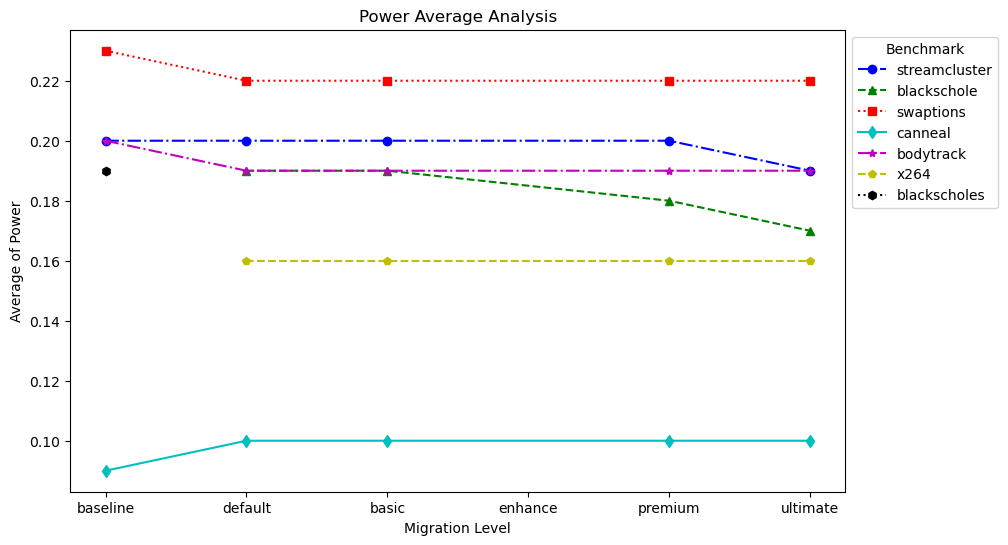

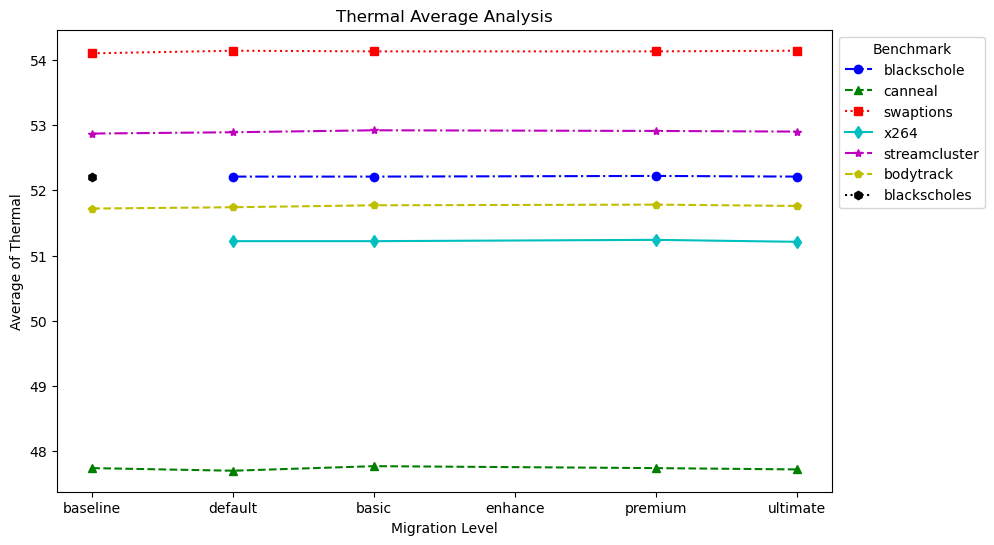

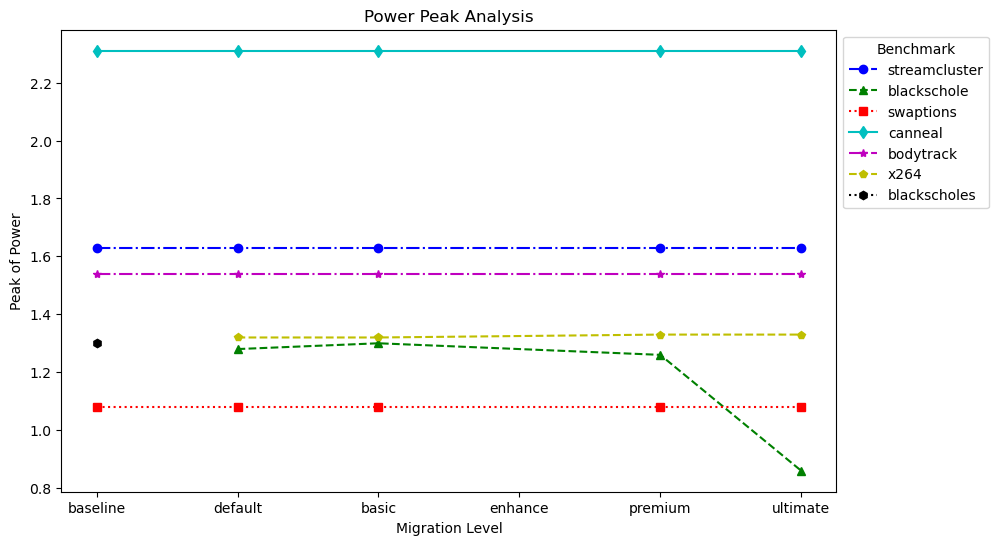

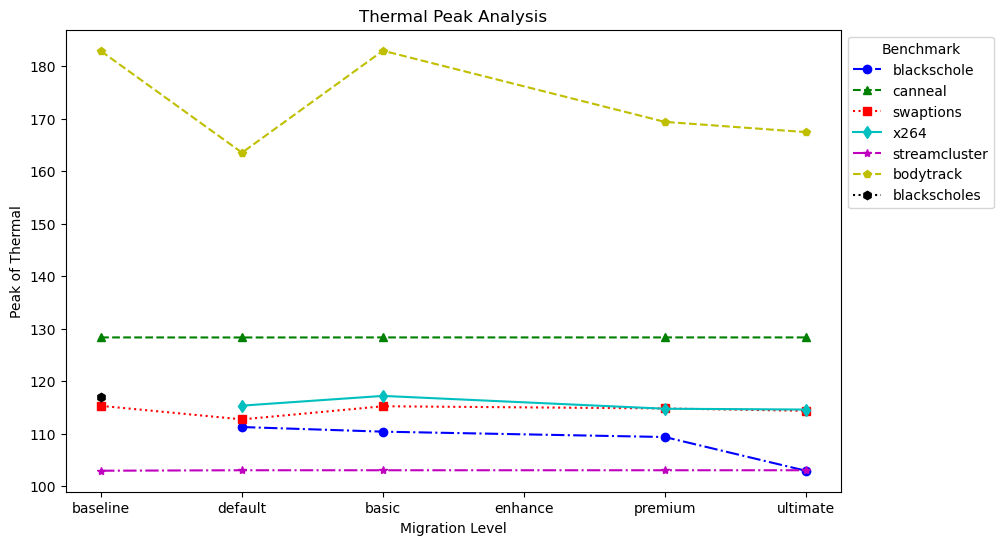

In [16]:
import pandas as pd
import os
from collections import defaultdict

def process_file(logfile_path):
    try:
        df = pd.read_csv(logfile_path, sep='\s+', header=None, skiprows=1)
    except Exception as e:
        print(f"Error reading {logfile_path}: {e}")
        return None

    if df.empty:
        return None

    filename = os.path.basename(logfile_path).split('_')
    metric_type = filename[0].replace('Periodic', '')  # "Power" or "Thermal"
    benchmark = filename[1]
    migration_level = filename[2].split('.')[0]  # "basic", "enhance", "premium", "ultimate", "default", "baseline"

    if metric_type == 'Power':
        df = df[df >= 0.01]

    avg_value = round(df.mean().mean(), 2) if not df.empty else 0
    peak_value = round(df.max().max(), 2) if not df.empty else 0

    return (metric_type, benchmark, migration_level, peak_value, avg_value)

def process_log_files(directory):
    results = []
    if not os.path.exists(directory):
        print("Directory does not exist")
        return results

    for filename in os.listdir(directory):
        if filename.endswith(".log"):
            filepath = os.path.join(directory, filename)
            result = process_file(filepath)
            if result:
                results.append(result)

    return results

log_directory = "./logs"
processed_results = process_log_files(log_directory)

import matplotlib.pyplot as plt
from collections import defaultdict

def plot_results(results, value_type):
    output_dir = 'charts'
    os.makedirs(output_dir, exist_ok=True)

    # Categorize data storage
    data = defaultdict(lambda: defaultdict(list))
    for record in results:
        metric_type, benchmark, migration_level, peak, avg = record
        value = avg if value_type == 'Average' else peak
        data[metric_type][benchmark].append((migration_level, value))

    migration_order = ['baseline', 'default', 'basic', 'enhance', 'premium', 'ultimate']

    for metric_type, benchmarks in data.items():
        fig, ax = plt.subplots(figsize=(10, 6))
        markers = ['o', '^', 's', 'd', '*', 'p', 'h', '+', 'x', 'v']
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']
        linestyles = ['-.', '--', ':', '-']

        for idx, (benchmark, values) in enumerate(benchmarks.items()):
            x_values = []
            y_values = []
            for level in migration_order:
                for value in values:
                    if value[0] == level:
                        x_values.append(migration_order.index(level))
                        y_values.append(value[1])
                        break

            if y_values:
                ax.plot(x_values, y_values, label=benchmark,
                        marker=markers[idx % len(markers)],
                        linestyle=linestyles[idx % len(linestyles)],
                        color=colors[idx % len(colors)])

        ax.set_xticks(range(len(migration_order)))
        ax.set_xticklabels(migration_order)
        ax.set_xlabel('Migration Level')
        ax.set_ylabel(f'{value_type} of {metric_type}')
        ax.set_title(f'{metric_type} {value_type} Analysis')
        plt.legend(title='Benchmark', loc='best', bbox_to_anchor=(1, 1))

        filename = f"{metric_type}_{value_type}_Analysis.pdf"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, bbox_inches='tight')
        plt.show()

plot_results(processed_results, 'Average')
plot_results(processed_results, 'Peak')
